In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from plotnine.data import mpg
import pandas as pd
import seaborn as sns
from pandas.api.types import CategoricalDtype
from plotnine import *

In [3]:
# Importar Keras y librerías adicionales
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

In [4]:
#Carga Data 
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
!ls
# Cargando data 
data = pd.read_csv('drive/My Drive/Proyecto Final INF648-0001/ObesityDataSet_raw_and_data_sinthetic.csv')
data.head()


drive  sample_data


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [6]:
#Validar data
data.isnull().sum()
#peso (kg) / [estatura (m)]2
data["IMC"]= data["Weight"]/(data["Height"]*data["Height"])


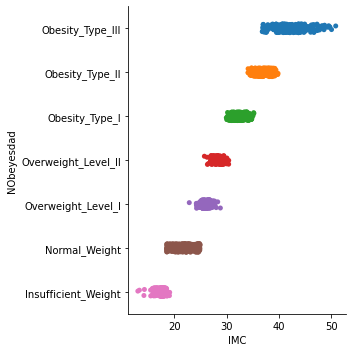

In [7]:
data["NObeyesdad"].unique()
#order = ['Insufficient_Weight','Normal_Weight','Overweight_Level_I','Overweight_Level_II','Obesity_Type_I','Obesity_Type_II','Obesity_Type_III']
order = ['Obesity_Type_III','Obesity_Type_II','Obesity_Type_I','Overweight_Level_II','Overweight_Level_I','Normal_Weight','Insufficient_Weight']
sns.catplot(x="IMC", y="NObeyesdad", data=data,order=order, height=5)

In [8]:
data.nunique()/len(data)

Gender                            0.000947
Age                               0.664140
Height                            0.745618
Weight                            0.722406
family_history_with_overweight    0.000947
FAVC                              0.000947
FCVC                              0.383704
NCP                               0.300805
CAEC                              0.001895
SMOKE                             0.000947
CH2O                              0.600663
SCC                               0.000947
FAF                               0.563714
TUE                               0.534818
CALC                              0.001895
MTRANS                            0.002369
NObeyesdad                        0.003316
IMC                               0.932260
dtype: float64

In [9]:
def preprocess_dataset(dataset, save_metadata=True):
  preprocessed_dataset = dataset.copy()

  #Determinamos aquellas variables que tengan un porcentaje de registros únicos por cada variable mayor al valor de 0.7
  threshold = 0.9

  unique_percentages = dataset.nunique() / len(dataset)

  criteria = unique_percentages > threshold

  columns_to_filter = unique_percentages[criteria].keys()

  #Eliminamos las variables seleccionadas en el paso anterior
  preprocessed_dataset.drop(columns_to_filter, axis=1, inplace=True)

  #Eliminamos los registros duplicados
  preprocessed_dataset.drop_duplicates(keep="first", inplace=True)

  #Determinamos que variables son del tipo númerico y cuales son categóricas
  numeric_columns = list()
  categorical_columns = list()
  dictionary_of_columns_with_index_to_categorical = dict()
  dictionary_of_columns_with_categorical_to_index = dict()

  for column in preprocessed_dataset:
    #Determinamos si la variable es numérica o no
    if pd.api.types.is_numeric_dtype(preprocessed_dataset[column]):
      numeric_columns.append(column)
    else:
      #Modificamos el tipo de dato de la variable mediante "astype"
      preprocessed_dataset[column] = preprocessed_dataset[column].astype("category")

      #Verificamos si el tipo de dato de la variable fue transformado a categórico correctamente
      if not pd.api.types.is_categorical_dtype(preprocessed_dataset[column]):
        raise Exception("La columna {} no se transformó correctamente a categórica".format(column))

      dictionary_of_columns_with_index_to_categorical[column] = dict()
      dictionary_of_columns_with_categorical_to_index[column] = dict()
      
      #Indexamos los valores (categorías), sin tomar en consideración los nulos, de la variable y guardamos esa información en los diccionarios
      for index, category in enumerate(preprocessed_dataset[column].cat.categories):
        dictionary_of_columns_with_index_to_categorical[column][index] = category
        dictionary_of_columns_with_categorical_to_index[column][category] = index
      
      categorical_columns.append(column)
  
  #Reemplazamos los nulos con la mediana sólo de aquellas variables numéricas
  median_of_numeric_columns = preprocessed_dataset[numeric_columns].median()

  preprocessed_dataset[numeric_columns] = preprocessed_dataset[numeric_columns].fillna(median_of_numeric_columns)

  #Transformamos a números los valores (categorías) de las variables categóricas sin considerar los nulos
  preprocessed_dataset.replace(dictionary_of_columns_with_categorical_to_index, inplace=True)

  #Determinamos aquellas variables que tengan un porcentaje de registros nulos por cada variable mayor al valor de 0.7
  threshold = 0.9

  null_percentages = preprocessed_dataset[categorical_columns].isna().sum() / len(preprocessed_dataset)

  criteria = null_percentages > threshold

  columns_to_filter = null_percentages[criteria].keys()

  #Eliminamos las variables seleccionadas en el paso anterior
  preprocessed_dataset.drop(columns_to_filter, axis=1, inplace=True)

  #Eliminamos los registros duplicados
  preprocessed_dataset.drop_duplicates(keep="first", inplace=True)

  #Generamos una nueva lista de variables categóricas sin contener "Embarked" y las variables eliminadas por tener un porcentaje alto de registros nulos
  categorical_columns_filtered = categorical_columns[:]


  for column in columns_to_filter:
    categorical_columns_filtered.remove(column)
  
  if len(categorical_columns_filtered) > 0:
    #Reemplazamos los nulos con la mediana para todas las variables excepto "Embarked" y las variables eliminadas por tener un porcentaje alto de registros nulos
    median_of_categorical_columns = preprocessed_dataset[categorical_columns_filtered].median()

    preprocessed_dataset[categorical_columns_filtered] = preprocessed_dataset[categorical_columns_filtered].fillna(median_of_categorical_columns)
  
  if save_metadata:
    #Guardamos información que consideremos imporante. El formato pickle nos permite guardar objetos de python
    with open("numeric_columns.pkl", "wb") as f:
      pickle.dump(numeric_columns, f)
    
    with open("categorical_columns.pkl", "wb") as f:
      pickle.dump(categorical_columns, f)
    
    with open("dictionary_of_columns_with_index_to_categorical.pkl", "wb") as f:
      pickle.dump(dictionary_of_columns_with_index_to_categorical, f)
    
    with open("dictionary_of_columns_with_categorical_to_index.pkl", "wb") as f:
      pickle.dump(dictionary_of_columns_with_categorical_to_index, f)
  
  return preprocessed_dataset

In [10]:
#Transformamos los datos a valores numéricos
preprocess_data = preprocess_dataset(data)
#preprocess_data.head()
#Guardamos nuestro dataset pre-procesado en formato pickle
preprocess_data.to_pickle("preprocess_data.pkl")
preprocess_data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,21.0,1.62,64.0,1,0,2.0,3.0,2,0,2.0,0,0.0,1.0,3,3,1
1,0,21.0,1.52,56.0,1,0,3.0,3.0,2,1,3.0,1,3.0,0.0,2,3,1
2,1,23.0,1.80,77.0,1,0,2.0,3.0,2,0,2.0,0,2.0,1.0,1,3,1
3,1,27.0,1.80,87.0,0,0,3.0,3.0,2,0,2.0,0,2.0,0.0,1,4,5
4,1,22.0,1.78,89.8,0,0,2.0,1.0,2,0,2.0,0,0.0,0.0,2,3,6


In [11]:
#Cargamos los datos previamente guardados
with open("numeric_columns.pkl", "rb") as f:
    numeric_columns = pickle.load(f)

with open("categorical_columns.pkl", "rb") as f:
  categorical_columns = pickle.load(f)

with open("dictionary_of_columns_with_index_to_categorical.pkl", "rb") as f:
  dictionary_of_columns_with_index_to_categorical = pickle.load(f)

with open("dictionary_of_columns_with_categorical_to_index.pkl", "rb") as f:
  dictionary_of_columns_with_categorical_to_index = pickle.load(f)

preprocessed_dataset = pd.read_pickle("preprocess_data.pkl")

In [ ]:
numeric_columns


['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

In [ ]:
categorical_columns

['Gender',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'CALC',
 'MTRANS',
 'NObeyesdad']

In [ ]:
dictionary_of_columns_with_index_to_categorical.keys()

dict_keys(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad'])

In [ ]:
#Vemos los índices que tienen los valores (categorías) de la columna (variable) "Embarked" para verificar que los nulos no están indexados
dictionary_of_columns_with_index_to_categorical["NObeyesdad"]

{0: 'Insufficient_Weight',
 1: 'Normal_Weight',
 2: 'Obesity_Type_I',
 3: 'Obesity_Type_II',
 4: 'Obesity_Type_III',
 5: 'Overweight_Level_I',
 6: 'Overweight_Level_II'}

In [ ]:
width = 20
height = 5

plt.style.use("default")

figure, axes = plt.subplots(nrows=2, ncols=9, figsize=(width, height))

for column, axe in zip(preprocess_data, axes.flatten()):
    sns.distplot(preprocess_data[column], ax=axe)
    
plt.tight_layout()

In [17]:
from sklearn.model_selection import train_test_split
X = preprocess_data.drop("Height",axis=1)
X = preprocess_data.drop("Weight",axis=1)
X = preprocess_data.drop("NObeyesdad",axis=1)
y = pd.DataFrame(preprocess_data["NObeyesdad"])

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=21)
X_train.head()
y_test.head()

,NObeyesdad
1150,6
1819,4
919,5
1217,2
299,5


In [18]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
x_train_scaled = sc_X.fit_transform(X_train)

In [38]:
# encode class values as integers
from keras.utils import np_utils
dummy_y = np_utils.to_categorical(y_train)
dummy_y

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [71]:
p = 0.001
# Inicializar la RNA
classifier = Sequential()

# Añadir las capas de entrada y primera capa oculta
classifier.add(Dense(units = 20, kernel_initializer = "uniform",  
                     activation = "sigmoid", input_dim = 16))
classifier.add(Dropout(p))

# Añadir la segunda capa oculta
classifier.add(Dense(units = 15, kernel_initializer = "uniform",  activation = "sigmoid"))
classifier.add(Dropout(p))
# Añadir la segunda capa oculta
classifier.add(Dense(units = 10, kernel_initializer = "uniform",  activation = "sigmoid"))
classifier.add(Dropout(p))

# Añadir la capa de salida
classifier.add(Dense(units = 7, kernel_initializer = "uniform",  activation = "softmax"))

# Compilar la RNA
classifier.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])


In [ ]:
# Ajustamos la RNA al Conjunto de Entrenamiento
log = classifier.fit(x_train_scaled, dummy_y,  batch_size = 15, epochs = 200)

In [ ]:
plt.plot(log.history['accuracy'], label='train')
plt.legend();
plt.plot(log.history['loss'], label='train')
plt.legend();

In [94]:
#calcualmos datos test 
sc_X = StandardScaler()
x_test_scaled = sc_X.fit_transform(X_test)
y_pred  = classifier.predict(x_test_scaled)

#y_test, y_pred
y_test_dummy = np_utils.to_categorical(y_test)
y_pred_dummy = np.vectorize(lambda x: int(x >= 0.5))(y_pred)
y_test_dummy

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [110]:
# calculate accuracy
y_pred_dummy.argmax(axis=1)
y_test_dummy.argmax(axis=1)

array([6, 4, 5, 2, 5, 2, 5, 1, 5, 1, 5, 0, 3, 0, 6, 2, 3, 4, 5, 5, 0, 1,
       5, 0, 6, 2, 4, 0, 0, 3, 1, 3, 3, 1, 0, 4, 2, 5, 5, 1, 6, 0, 0, 2,
       3, 4, 4, 4, 6, 0, 6, 5, 1, 6, 2, 0, 5, 6, 4, 1, 1, 4, 6, 5, 2, 1,
       0, 6, 0, 6, 6, 1, 2, 1, 4, 6, 3, 3, 5, 6, 5, 4, 5, 6, 0, 4, 4, 5,
       6, 1, 5, 3, 6, 1, 6, 2, 3, 1, 5, 6, 6, 4, 4, 2, 1, 4, 6, 0, 3, 0,
       2, 2, 3, 2, 3, 1, 5, 6, 6, 5, 4, 3, 3, 5, 3, 0, 2, 6, 0, 3, 4, 5,
       4, 5, 1, 6, 5, 2, 4, 1, 6, 1, 5, 5, 0, 0, 0, 4, 5, 4, 1, 1, 5, 4,
       3, 4, 6, 6, 4, 5, 4, 4, 1, 0, 3, 2, 1, 0, 1, 0, 1, 0, 3, 2, 6, 5,
       3, 6, 2, 4, 0, 5, 4, 4, 0, 1, 6, 1, 6, 3, 4, 6, 5, 5, 6, 6, 4, 1,
       5, 6, 3, 2, 2, 4, 1, 3, 2, 5, 0, 5, 0, 5, 4, 1, 2, 1, 2, 5, 1, 4,
       1, 5, 4, 3, 2, 2, 4, 4, 3, 1, 1, 6, 5, 2, 2, 5, 6, 6, 4, 1, 6, 0,
       0, 0, 2, 4, 0, 5, 4, 3, 4, 2, 3, 0, 3, 0, 2, 6, 2, 3, 5, 0, 2, 4,
       6, 6, 6, 1, 2, 0, 4, 6, 4, 5, 4, 3, 3, 0, 4, 3, 1, 4, 4, 3, 6, 4,
       4, 3, 6, 5, 0, 2, 0, 4, 3, 3, 3, 6, 0, 2, 6,

In [115]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
cm = confusion_matrix(y_test_dummy.argmax(axis=1), y_pred_dummy.argmax(axis=1))
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
print('Model Performance')
print('Accuracy = {:0.4f}%.'.format(metrics.accuracy_score(y_test_dummy, y_pred_dummy)))
print('Recall = {:0.4f}%.'.format(np.mean(recall)))
print('Precision = {:0.4f}%.'.format(np.mean(precision)))
print('Matrix confussion')
cm

Model Performance
Accuracy = 0.9569%.
Recall = 0.9554%.
Precision = 0.9562%.
Matrix confussion


array([[55,  0,  0,  0,  0,  0,  0],
       [ 4, 48,  0,  0,  0,  2,  0],
       [ 0,  0, 52,  0,  0,  0,  2],
       [ 0,  0,  2, 53,  0,  0,  0],
       [ 0,  0,  0,  0, 75,  0,  0],
       [ 0,  2,  0,  0,  0, 59,  1],
       [ 0,  0,  2,  0,  0,  3, 58]])

In [ ]:
from sklearn.metrics import roc_curve
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()


fper, tper, thresholds = roc_curve(y_test_dummy.argmax(axis=1), y_pred_dummy.argmax(axis=1), pos_label='1')
plot_roc_curve(fper, tper)